Title: Classifying Tuberculosis (TB) and Normal Chest X-ray Images<br>

## 0.Dataset

[Kaggle]<br>
https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset?resource=download

This dataset is originally from the following report.<br>
Tawsifur Rahman, Amith Khandakar, Muhammad A. Kadir, Khandaker R. Islam, Khandaker F. Islam, Zaid B. Mahbub, Mohamed Arselene Ayari, Muhammad E. H. Chowdhury. (2020)<br> "Reliable Tuberculosis Detection using Chest X-ray with Deep Learning, Segmentation and Visualization".<br>
IEEE Access, Vol. 8, pp 191586 - 191601. DOI. 10.1109/ACCESS.2020.3031384.


## 1.Codes

### 1.1.Preprocess data

In [ ]:
!pip install shap

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import shap
from skimage.io import imread
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,Dropout,BatchNormalization,Activation
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers,Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications import DenseNet201

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set folders storing images
folder = '/content/drive/My Drive/USC/Share/DSO569/'
folder_normal = folder +'Normal/'
folder_tuber = folder + 'Tuberculosis/'

# Get file names in each folder
file_normal = os.listdir(folder_normal)
file_tuber = os.listdir(folder_tuber)

# Store filapaths into pandas DataFrame
df_normal =pd.DataFrame(file_normal,columns=["images"])
df_normal["labels"] = 0
df_normal["images"]=folder_normal+df_normal["images"]

df_tuber=pd.DataFrame(file_tuber,columns=["images"])
df_tuber["labels"] = 1
df_tuber["images"]=folder_tuber+df_tuber["images"]

In [ ]:
# Load images
df_merge =pd.concat([df_normal,df_tuber],ignore_index=True)
df_merge['matrix_img'] = df_merge['images'].apply(lambda x: cv2.resize(cv2.imread(x,0) ,(224, 224)))
df_merge.sample(frac=1, random_state=42).reset_index(drop=True)

,images,labels,matrix_img
0,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[4, 6, 4, 4, 4, 4, 4, 3, 3, 6, 9, 13, 13, 16,..."
2,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[201, 187, 140, 81, 40, 20, 8, 3, 3, 4, 6, 7,..."
3,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[1, 15, 9, 6, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3..."
4,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[0, 0, 0, 0, 0, 22, 24, 21, 21, 21, 22, 21, 2..."
...,...,...,...
4195,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[23, 33, 34, 26, 23, 22, 23, 26, 30, 37, 41, ..."
4196,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4197,/content/drive/My Drive/USC/Share/DSO569/Norma...,0,"[[94, 78, 66, 55, 45, 38, 34, 32, 33, 33, 34, ..."
4198,/content/drive/My Drive/USC/Share/DSO569/Tuber...,1,"[[11, 11, 10, 10, 11, 11, 11, 11, 11, 11, 11, ..."


labels
0    3500
1     700
Name: count, dtype: int64


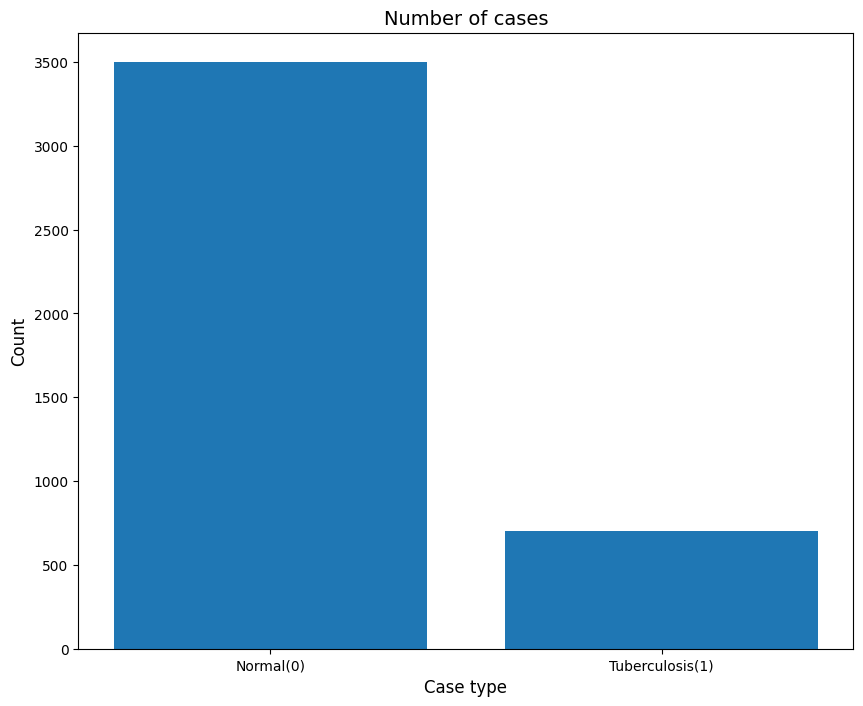

In [ ]:
# Get the counts for each class
cases_count = df_merge['labels'].value_counts()
print(cases_count)

# Plot the results
plt.figure(figsize=(10,8))
plt.bar(cases_count.index,cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()

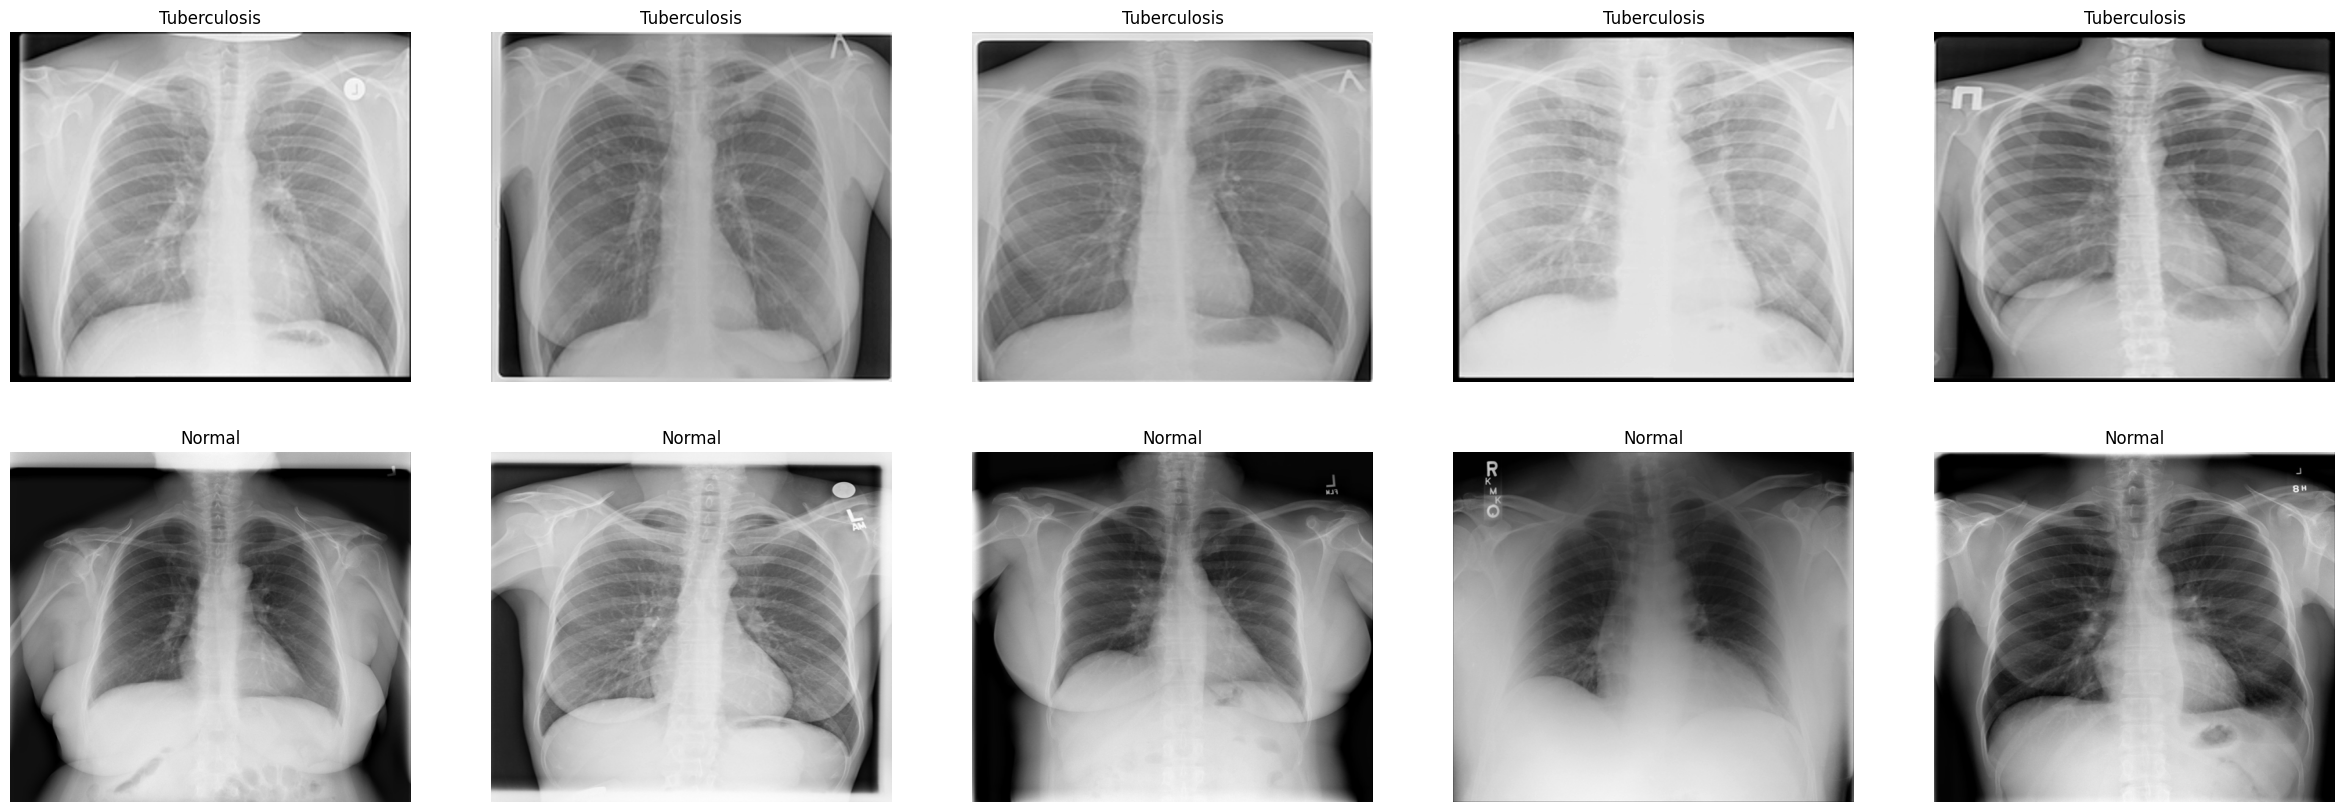

In [ ]:
# Get few samples for both the classes
Tuberculosis_samples = (df_merge[df_merge['labels']==1]['images'].iloc[:5]).tolist()
normal_samples = (df_merge[df_merge['labels']==0]['images'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = Tuberculosis_samples + normal_samples
del Tuberculosis_samples, normal_samples

# Plot the data
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Tuberculosis")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

In [ ]:
# Set x and y
X=df_merge["matrix_img"]
y=df_merge["labels"]

# normalize to range 0-1
X = X / 255.0

In [ ]:
# split data in train_data and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                 test_size=0.20,
                                                 random_state=42,
                                                 stratify=y)

In [ ]:
# change data into tensor
X_train = np.array([np.array(x, dtype=np.float32) for x in X_train], dtype=object)
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val = np.array([np.array(x, dtype=np.float32) for x in X_val], dtype=object)
X_val = tf.convert_to_tensor(X_val, dtype=tf.float32)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(3360, 224, 224)
(3360,)
(840, 224, 224)
(840,)


### 1.2.Build DNN models

In [ ]:
# Define the model
def create_simple_dnn_with_dropput(num_hidden_layer,dr_rate=0.5):
  model = Sequential()
  model.add(Flatten(input_shape=(224,224)))
  # Add hidden layers in accordance with num_hidden_layer
  if num_hidden_layer != 0:
    for i in range (num_hidden_layer):
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(dr_rate))
  model.add(Dense(1,activation='sigmoid'))

  # compile model
  # Since the label is binary, use BinaryCrossentropy as the loss function
  model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model

In [ ]:
# DNN with 1 hidden layer and 128 hidden neurons with dropout layer
dnn1_dr = create_simple_dnn_with_dropput(1)
dnn1_dr.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 50176)             0         
                                                                 
 dense_23 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_24 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6422785 (24.50 MB)
Trainable params: 6422785 (24.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# DNN with 2 hidden layer of 128 hidden neurons with dropout layer
dnn2_dr = create_simple_dnn_with_dropput(2)
dnn2_dr.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 50176)             0         
                                                                 
 dense_25 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               16512     
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 129       
                                                                 
Total params: 6439297 (24.56 MB)
Trainable params: 643

In [ ]:
# DNN with 3 hidden layer of 128 hidden neurons with dropout layer
dnn3_dr = create_simple_dnn_with_dropput(3)
dnn3_dr.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 50176)             0         
                                                                 
 dense_28 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_19 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 128)               16512     
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 128)               16512     
                                                                 
 dropout_21 (Dropout)        (None, 128)              

In [ ]:
# DNN with 4 hidden layer of 128 hidden neurons with dropout layer
dnn4_dr = create_simple_dnn_with_dropput(4)
dnn4_dr.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 50176)             0         
                                                                 
 dense_32 (Dense)            (None, 128)               6422656   
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 128)               16512     
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_34 (Dense)            (None, 128)               16512     
                                                                 
 dropout_24 (Dropout)        (None, 128)             

In [ ]:
# Use the callback list method with checkpoint to fit the model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [ ]:
# Dnn1 with dropout layer and epoch 50
fit_dnn1_dr = dnn1_dr.fit(X_train,  y_train, epochs=50,
                    batch_size=64, validation_data=(X_val,  y_val),
                    callbacks=callbacks_list)

dnn1_dr = keras.models.load_model("checkpoint_path.keras")
dnn1_dr.evaluate(X_val,  y_val, verbose=2)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


53/53 [==============================] - 2s 15ms/step - loss: 1.7395 - accuracy: 0.8226 - val_loss: 0.2841 - val_accuracy: 0.9095
Epoch 2/50
53/53 [==============================] - 0s 8ms/step - loss: 0.2842 - accuracy: 0.8768 - val_loss: 0.2255 - val_accuracy: 0.8810
Epoch 3/50
53/53 [==============================] - 0s 8ms/step - loss: 0.2689 - accuracy: 0.8839 - val_loss: 0.2289 - val_accuracy: 0.8845
Epoch 4/50
53/53 [==============================] - 1s 12ms/step - loss: 0.2576 - accuracy: 0.8896 - val_loss: 0.1841 - val_accuracy: 0.9321
Epoch 5/50
53/53 [==============================] - 0s 7ms/step - loss: 0.2489 - accuracy: 0.8955 - val_loss: 0.1927 - val_accuracy: 0.8964
Epoch 6/50
53/53 [==============================] - 1s 13ms/step - loss: 0.2581 - accuracy: 0.8729 - val_loss: 0.1904 - val_accuracy: 0.9381
Epoch 7/50
53/53 [==============================] - 0s 8ms/step - loss: 0.2491 - accuracy: 0.8815 - val_loss: 0.1842 - val_accuracy: 0.9071
Epoch 8/50
53/53 [==========

[0.13208651542663574, 0.961904764175415]

In [ ]:
# Dnn2 with dropout layer and epoch 50
fit_dnn2_dr = dnn2_dr.fit(X_train,  y_train, epochs=50,
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=callbacks_list)

dnn2_dr = keras.models.load_model("checkpoint_path.keras")
dnn2_dr.evaluate(X_val,  y_val, verbose=2)

Epoch 1/50
53/53 [==============================] - 2s 11ms/step - loss: 1.7066 - accuracy: 0.7613 - val_loss: 0.2661 - val_accuracy: 0.8333
Epoch 2/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4412 - accuracy: 0.8265 - val_loss: 0.4204 - val_accuracy: 0.8333
Epoch 3/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4318 - accuracy: 0.8321 - val_loss: 0.3260 - val_accuracy: 0.8333
Epoch 4/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4669 - accuracy: 0.8333 - val_loss: 0.4778 - val_accuracy: 0.8333
Epoch 5/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4675 - accuracy: 0.8333 - val_loss: 0.4561 - val_accuracy: 0.8333
Epoch 6/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4563 - accuracy: 0.8333 - val_loss: 0.4515 - val_accuracy: 0.8333
Epoch 7/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4547 - accuracy: 0.8333 - val_loss: 0.4508 - val_accuracy: 0.8333
Epoch 8/50
53/53 [=

[0.13208651542663574, 0.961904764175415]

In [ ]:
# Dnn3 with dropout layer and epoch 50
fit_dnn3_dr = dnn3_dr.fit(X_train,  y_train, epochs=50,
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=callbacks_list)

dnn3_dr = keras.models.load_model("checkpoint_path.keras")
dnn3_dr.evaluate(X_val,  y_val, verbose=2)

Epoch 1/50
53/53 [==============================] - 2s 11ms/step - loss: 1.9428 - accuracy: 0.7699 - val_loss: 0.3068 - val_accuracy: 0.8333
Epoch 2/50
53/53 [==============================] - 0s 8ms/step - loss: 0.5413 - accuracy: 0.8318 - val_loss: 0.5086 - val_accuracy: 0.8333
Epoch 3/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4854 - accuracy: 0.8333 - val_loss: 0.4609 - val_accuracy: 0.8333
Epoch 4/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4608 - accuracy: 0.8333 - val_loss: 0.4518 - val_accuracy: 0.8333
Epoch 5/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4548 - accuracy: 0.8333 - val_loss: 0.4508 - val_accuracy: 0.8333
Epoch 6/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4564 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 7/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4566 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 8/50
53/53 [=

[0.13208651542663574, 0.961904764175415]

In [ ]:
# Dnn4 with dropout layer and epoch 50
fit_dnn4_dr = dnn4_dr.fit(X_train,  y_train, epochs=50,
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=callbacks_list)

dnn4_dr = keras.models.load_model("checkpoint_path.keras")
dnn4_dr.evaluate(X_val,  y_val, verbose=2)

Epoch 1/50
53/53 [==============================] - 2s 11ms/step - loss: 1.8077 - accuracy: 0.7607 - val_loss: 0.4621 - val_accuracy: 0.8333
Epoch 2/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4343 - accuracy: 0.8295 - val_loss: 0.3581 - val_accuracy: 0.8333
Epoch 3/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4209 - accuracy: 0.8313 - val_loss: 0.3568 - val_accuracy: 0.8333
Epoch 4/50
53/53 [==============================] - 0s 8ms/step - loss: 0.4632 - accuracy: 0.8333 - val_loss: 0.4517 - val_accuracy: 0.8333
Epoch 5/50
53/53 [==============================] - 0s 9ms/step - loss: 0.4563 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 6/50
53/53 [==============================] - 0s 9ms/step - loss: 0.4556 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 7/50
53/53 [==============================] - 0s 9ms/step - loss: 0.4528 - accuracy: 0.8333 - val_loss: 0.4506 - val_accuracy: 0.8333
Epoch 8/50
53/53 [=

[0.13208651542663574, 0.961904764175415]

In [ ]:
# Define the dictionaries
dnn1_dr_dict = fit_dnn1_dr.history
dnn1_dr_accuracy = dnn1_dr_dict["accuracy"]
dnn1_dr_val_accuracy = dnn1_dr_dict["val_accuracy"]
epochs = range(1, len(dnn1_dr_accuracy) + 1)
dnn2_dr_dict = fit_dnn2_dr.history
dnn2_dr_accuracy = dnn2_dr_dict["accuracy"]
dnn2_dr_val_accuracy = dnn2_dr_dict["val_accuracy"]
dnn3_dr_dict = fit_dnn3_dr.history
dnn3_dr_accuracy = dnn3_dr_dict["accuracy"]
dnn3_dr_val_accuracy = dnn3_dr_dict["val_accuracy"]
dnn4_dr_dict = fit_dnn4_dr.history
dnn4_dr_accuracy = dnn4_dr_dict["accuracy"]
dnn4_dr_val_accuracy = dnn4_dr_dict["val_accuracy"]

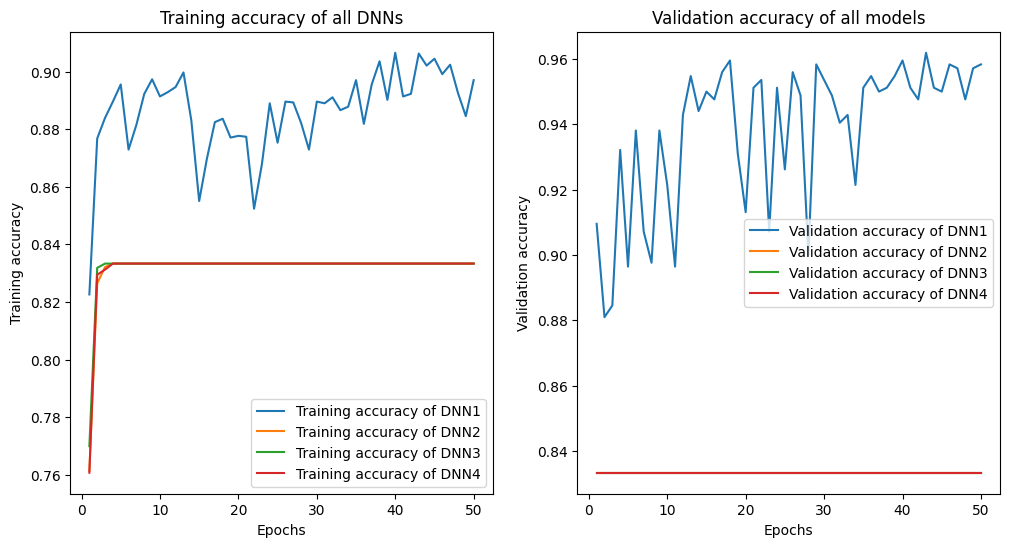

In [ ]:
# Plot all data in graphs

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Training accuracy of all models
axs[0].plot(epochs, dnn1_dr_accuracy, label="Training accuracy of DNN1")
axs[0].plot(epochs, dnn2_dr_accuracy, label="Training accuracy of DNN2")
axs[0].plot(epochs, dnn3_dr_accuracy, label="Training accuracy of DNN3")
axs[0].plot(epochs, dnn4_dr_accuracy, label="Training accuracy of DNN4")
axs[0].set_title("Training accuracy of all DNNs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Training accuracy')
axs[0].legend()

# Validation accuracy of all models
axs[1].plot(epochs, dnn1_dr_val_accuracy, label="Validation accuracy of DNN1")
axs[1].plot(epochs, dnn2_dr_val_accuracy, label="Validation accuracy of DNN2")
axs[1].plot(epochs, dnn3_dr_val_accuracy, label="Validation accuracy of DNN3")
axs[1].plot(epochs, dnn4_dr_val_accuracy, label="Validation accuracy of DNN4")
axs[1].set_title("Validation accuracy of all DNNs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Validation accuracy')
axs[1].legend()

plt.show()

### 1.2.Build CNN models

In [ ]:
## CNN with 3 convolution layers, each accompanied with a max pooling layer
def create_model_cnn(act_func):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation=act_func,
                   padding='same', input_shape=(224, 224, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation=act_func, padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation=act_func))
  model.add(Conv2D(128, (3, 3), activation=act_func))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation=act_func))
  model.add(Dense(1, activation='sigmoid'))

  # compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
## CNN with 3 convolution layers + dropout layer, each accompanied with a max pooling layer
def create_model_cnn_with_dr(act_func,dropout_rate = 0.5):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation=act_func,
                   padding='same', input_shape=(224, 224, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation=act_func, padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation=act_func))
  model.add(Conv2D(128, (3, 3), activation=act_func))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation=act_func))
  # Put Dropout layer right before the output layer
  model.add(Dropout(dropout_rate))

  model.add(Dense(1, activation='sigmoid'))

  # compile model
  model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])

  return model

In [ ]:
# Build the model
cnn_relu = create_model_cnn('relu')
cnn_relu.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_189 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_190 (Conv2D)         (None, 54, 54, 128)       73856     
                                                                 
 conv2d_191 (Conv2D)         (None, 52, 52, 128)     

In [ ]:
# Build the model
cnn_relu_with_dr = create_model_cnn_with_dr('relu')
cnn_relu_with_dr.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_192 (Conv2D)         (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_193 (Conv2D)         (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 56, 56, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_194 (Conv2D)         (None, 54, 54, 128)       73856     
                                                                 
 conv2d_195 (Conv2D)         (None, 52, 52, 128)     

In [ ]:
# we use the callback list method with checkpoint to fit the model
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

In [ ]:
# fit CNN with relu function with dropout with 50 epochs
fit_cnn = cnn_relu.fit(X_train,  y_train, epochs=50,
                  batch_size=64, validation_data=(X_val, y_val),
                  callbacks=callbacks_list)

cnn_relu = keras.models.load_model("checkpoint_path.keras")
cnn_relu.evaluate(X_val, y_val, verbose=2)

Epoch 1/50
53/53 [==============================] - 7s 56ms/step - loss: 0.2969 - accuracy: 0.8690 - val_loss: 0.2293 - val_accuracy: 0.9024
Epoch 2/50
53/53 [==============================] - 2s 35ms/step - loss: 0.1315 - accuracy: 0.9497 - val_loss: 0.1714 - val_accuracy: 0.9286
Epoch 3/50
53/53 [==============================] - 2s 33ms/step - loss: 0.1032 - accuracy: 0.9625 - val_loss: 0.1294 - val_accuracy: 0.9679
Epoch 4/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.1178 - val_accuracy: 0.9524
Epoch 5/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0551 - accuracy: 0.9818 - val_loss: 0.0764 - val_accuracy: 0.9726
Epoch 6/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0429 - accuracy: 0.9854 - val_loss: 0.0958 - val_accuracy: 0.9655
Epoch 7/50
53/53 [==============================] - 2s 33ms/step - loss: 0.0393 - accuracy: 0.9863 - val_loss: 0.0458 - val_accuracy: 0.9845
Epoch 8/50
53

[0.04774702340364456, 0.9916666746139526]

In [ ]:
# fit CNN with relu function with dropout with 50 epochs
fit_cnn_with_dr = cnn_relu_with_dr.fit(X_train,  y_train, epochs=50,
                  batch_size=64, validation_data=(X_val, y_val),
                  callbacks=callbacks_list)

cnn_relu_with_dr = keras.models.load_model("checkpoint_path.keras")
cnn_relu_with_dr.evaluate(X_val, y_val, verbose=2)

Epoch 1/50
53/53 [==============================] - 3s 26ms/step - loss: 0.3269 - accuracy: 0.8655 - val_loss: 0.2286 - val_accuracy: 0.8738
Epoch 2/50
53/53 [==============================] - 1s 22ms/step - loss: 0.2276 - accuracy: 0.8997 - val_loss: 0.1546 - val_accuracy: 0.9464
Epoch 3/50
53/53 [==============================] - 1s 22ms/step - loss: 0.1428 - accuracy: 0.9375 - val_loss: 0.1098 - val_accuracy: 0.9560
Epoch 4/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0968 - accuracy: 0.9625 - val_loss: 0.0891 - val_accuracy: 0.9643
Epoch 5/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0774 - accuracy: 0.9723 - val_loss: 0.1062 - val_accuracy: 0.9619
Epoch 6/50
53/53 [==============================] - 1s 23ms/step - loss: 0.0840 - accuracy: 0.9688 - val_loss: 0.0885 - val_accuracy: 0.9750
Epoch 7/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0582 - accuracy: 0.9795 - val_loss: 0.0666 - val_accuracy: 0.9750
Epoch 8/50
53

[0.013270708732306957, 0.9964285492897034]

In [ ]:
# The y-axis is the test (validation) accuracy and the x-axis is the number of epochs (# of passes through the training set).

cnn_relu_dict = fit_cnn.history
cnn_relu_accuracy = cnn_relu_dict["accuracy"]
cnn_relu_val_accuracy = cnn_relu_dict["val_accuracy"]
epochs = range(1, len(cnn_relu_val_accuracy) + 1)
cnn_relu_with_dr_dict = fit_cnn_with_dr.history
cnn_relu_with_dr_accuracy = cnn_relu_with_dr_dict["accuracy"]
cnn_relu_with_dr_val_accuracy = cnn_relu_with_dr_dict["val_accuracy"]

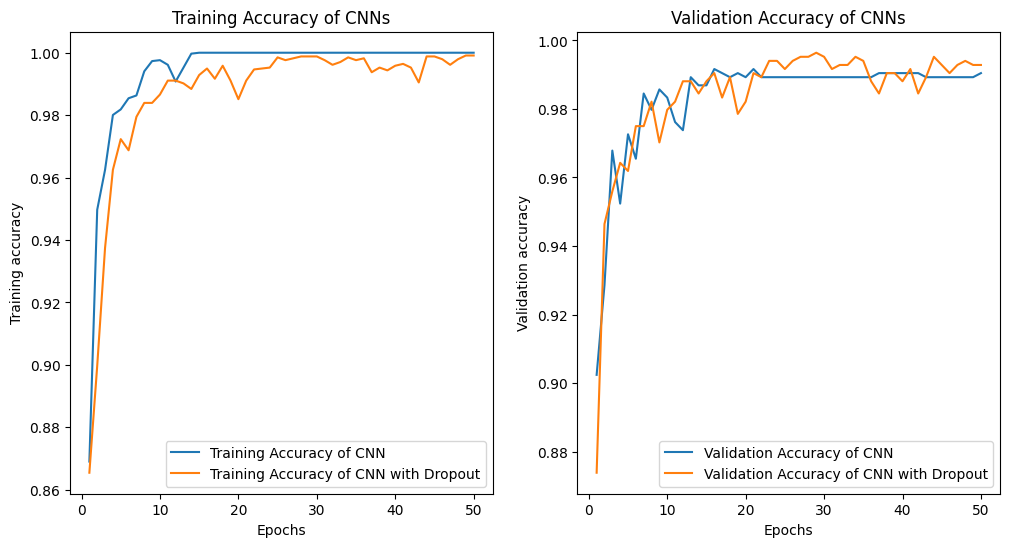

In [ ]:
# Plot all data in graphs
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Traning accuracy of CNNs
axs[0].plot(epochs, cnn_relu_accuracy, label="Training Accuracy of CNN")
axs[0].plot(epochs, cnn_relu_with_dr_accuracy, label="Training Accuracy of CNN with Dropout")
axs[0].set_title("Training Accuracy of CNNs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Training accuracy')
axs[0].legend()

# Validation accuracy of CNNs
axs[1].plot(epochs, cnn_relu_val_accuracy, label="Validation Accuracy of CNN")
axs[1].plot(epochs, cnn_relu_with_dr_val_accuracy, label="Validation Accuracy of CNN with Dropout")
axs[1].set_title("Validation Accuracy of CNNs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Validation accuracy')
axs[1].legend()

plt.show()

### 1.3.Build pre-trained models

In [ ]:
## download the pretrained model weights

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2024-05-05 18:11:53--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 172.253.118.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  22.4MB/s    in 4.9s    

2024-05-05 18:11:59 (17.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [ ]:
# Use InceptionV3
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(
    input_shape=(75, 75, 3), include_top=False, weights=None)
pre_trained_model.load_weights(local_weights_file)

In [ ]:
# Build the model
for layer in pre_trained_model.layers:
  layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
## Add a fully connected layer with 64 hidden units and ReLU activation
x = layers.Dense(64, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

# Configure and compile the model
inceptionV3 = Model(pre_trained_model.input, x)
inceptionV3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])
inceptionV3.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 75, 75, 3)]          0         []                            
                                                                                                  
 conv2d_196 (Conv2D)         (None, 37, 37, 32)           864       ['input_6[0][0]']             
                                                                                                  
 batch_normalization_191 (B  (None, 37, 37, 32)           96        ['conv2d_196[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_188 (Activation  (None, 37, 37, 32)           0         ['batch_normalization_19

In [ ]:
# Since InceptionV3 needs color images, put fake colors in images
X_train_RGB = np.stack((X_train, X_train, X_train),axis=3)
X_val_RGB = np.stack((X_val,X_val,X_val),axis=3)

X_val_RGB.shape

(840, 224, 224, 3)

In [ ]:
## resize the images; 75 x 75 is the smallest size that InceptionV3 can take

X_train_resize_75 = tf.image.resize(X_train_RGB, (75, 75))
X_val_resize_75 = tf.image.resize(X_val_RGB, (75, 75))
X_train_resize_75.shape

TensorShape([3360, 75, 75, 3])

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

history1 = inceptionV3.fit(X_train_resize_75,  y_train, epochs=50,
          batch_size=64, validation_data=(X_val_resize_75, y_val),
          callbacks=callbacks_list)

inceptionV3 = tf.keras.models.load_model("checkpoint_path.keras")
inceptionV3.evaluate(X_val_resize_75, y_val)

Epoch 1/50
53/53 [==============================] - 4s 27ms/step - loss: 0.0055 - accuracy: 0.9994 - val_loss: 0.0351 - val_accuracy: 0.9917
Epoch 2/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0291 - val_accuracy: 0.9893
Epoch 3/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0291 - val_accuracy: 0.9869
Epoch 4/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 0.0278 - val_accuracy: 0.9940
Epoch 5/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0292 - val_accuracy: 0.9917
Epoch 6/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0034 - accuracy: 0.9997 - val_loss: 0.0307 - val_accuracy: 0.9893
Epoch 7/50
53/53 [==============================] - 1s 11ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.0280 - val_accuracy: 0.9929
Epoch 8/50
53

[0.027766143903136253, 0.9940476417541504]

In [ ]:
# Build another pre-trained models: DenseNet201

def build_model(backbone):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

densenet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(32,32,3)
)

densenet201 = build_model(densenet)
densenet201.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 1, 1, 1920)        18321984  
                                                                 
 global_average_pooling2d_4  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_29 (Dropout)        (None, 1920)              0         
                                                                 
 batch_normalization_286 (B  (None, 1920)              7680      
 atchNormalization)                                              
                                                                 
 dense_44 (Dense)            (None, 1)                 1921      
                                                                 
Total params: 18331585 (69.93 MB)
Trainable params: 1

In [ ]:
## resize the images; 32 x 32 is the smallest size that the Densenet201 can take
X_train_resize_32 = tf.image.resize(X_train_RGB, (32, 32))
X_val_resize_32 = tf.image.resize(X_val_RGB, (32, 32))
X_train_resize_32.shape

TensorShape([3360, 32, 32, 3])

In [ ]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_accuracy",
        save_best_only=True,
    )
]

history2 = densenet201.fit(X_train_resize_32,  y_train, epochs=50,
          batch_size=64, validation_data=(X_val_resize_32, y_val),
          callbacks=callbacks_list)

densenet201 = tf.keras.models.load_model("checkpoint_path.keras")
densenet201.evaluate(X_val_resize_32, y_val)

Epoch 1/50
53/53 [==============================] - 106s 266ms/step - loss: 0.2571 - accuracy: 0.9060 - val_loss: 1.6530 - val_accuracy: 0.7631
Epoch 2/50
53/53 [==============================] - 12s 227ms/step - loss: 0.0837 - accuracy: 0.9741 - val_loss: 1.1559 - val_accuracy: 0.9214
Epoch 3/50
53/53 [==============================] - 7s 134ms/step - loss: 0.0401 - accuracy: 0.9851 - val_loss: 0.2329 - val_accuracy: 0.8940
Epoch 4/50
53/53 [==============================] - 11s 200ms/step - loss: 0.0461 - accuracy: 0.9836 - val_loss: 0.0733 - val_accuracy: 0.9774
Epoch 5/50
53/53 [==============================] - 7s 131ms/step - loss: 0.0216 - accuracy: 0.9935 - val_loss: 0.0738 - val_accuracy: 0.9750
Epoch 6/50
53/53 [==============================] - 7s 132ms/step - loss: 0.0399 - accuracy: 0.9896 - val_loss: 0.1733 - val_accuracy: 0.9131
Epoch 7/50
53/53 [==============================] - 7s 130ms/step - loss: 0.0239 - accuracy: 0.9914 - val_loss: 0.2114 - val_accuracy: 0.8881
Ep

[0.03212219476699829, 0.9952380657196045]

In [ ]:
# The y-axis is the test (validation) accuracy and the x-axis is the number of epochs (# of passes through the training set).
inc_dict = history1.history
inc_accuracy = inc_dict["accuracy"]
inc_val_accuracy = inc_dict["val_accuracy"]
epochs = range(1, len(inc_val_accuracy) + 1)
dense_dict = history2.history
dense_accuracy = dense_dict["accuracy"]
dense_val_accuracy = dense_dict["val_accuracy"]

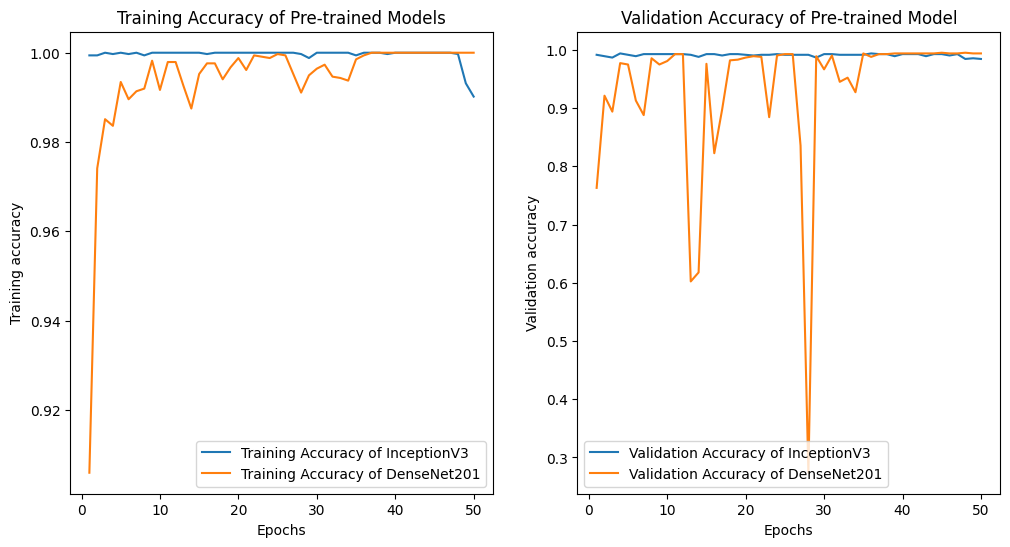

In [ ]:
# Plot data in a graph
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Traning accuracy of Pre-trained Model
axs[0].plot(epochs, inc_accuracy, label="Training Accuracy of InceptionV3")
axs[0].plot(epochs, dense_accuracy, label="Training Accuracy of DenseNet201")
axs[0].set_title("Training Accuracy of Pre-trained Models")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Training accuracy')
axs[0].legend()

# Validation accuracy of Pre-trained Model
axs[1].plot(epochs, inc_val_accuracy, label="Validation Accuracy of InceptionV3")
axs[1].plot(epochs, dense_val_accuracy, label="Validation Accuracy of DenseNet201")
axs[1].set_title("Validation Accuracy of Pre-trained Model")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Validation accuracy')
axs[1].legend()

plt.show()

## 2.Plot all results

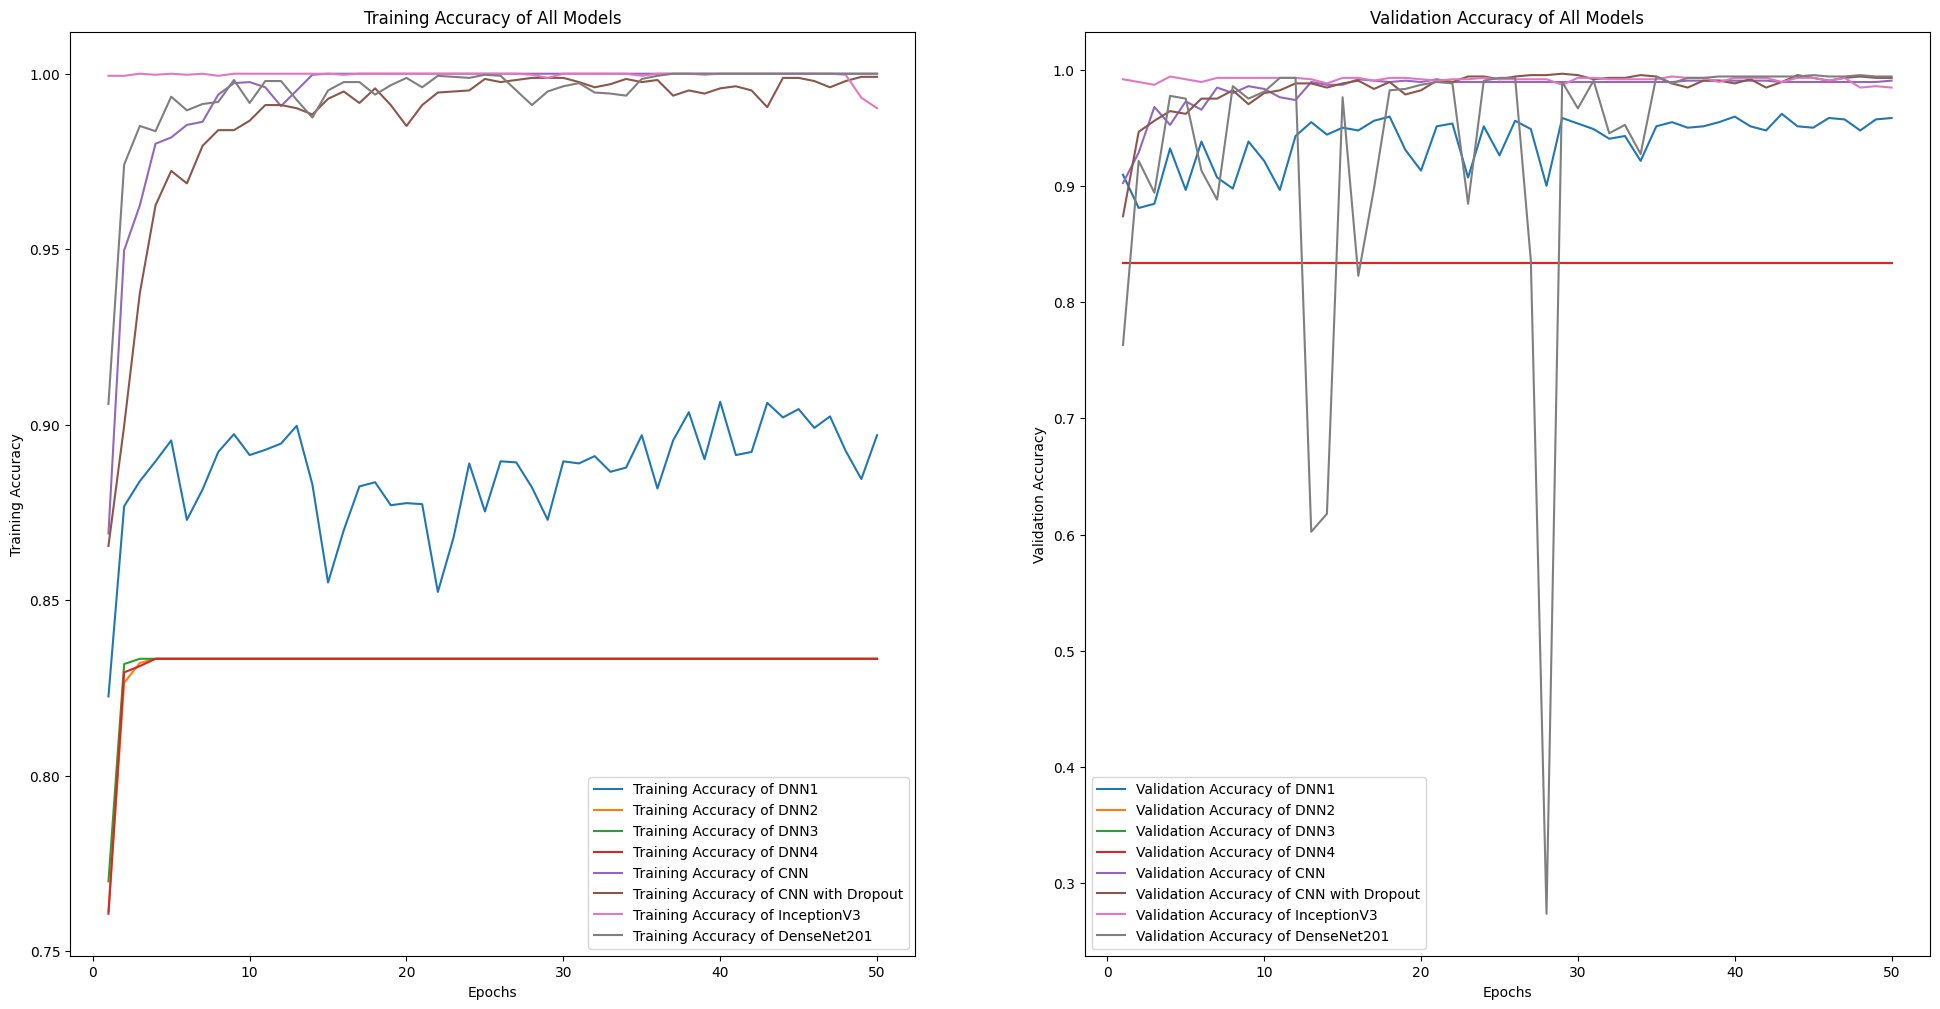

In [ ]:
# Plot all data in graphs

fig, axs = plt.subplots(1, 2, figsize=(24, 12))

# Validation losses of all models
axs[0].plot(epochs, dnn1_dr_accuracy, label="Training Accuracy of DNN1")
axs[0].plot(epochs, dnn2_dr_accuracy, label="Training Accuracy of DNN2")
axs[0].plot(epochs, dnn3_dr_accuracy, label="Training Accuracy of DNN3")
axs[0].plot(epochs, dnn4_dr_accuracy, label="Training Accuracy of DNN4")
axs[0].plot(epochs, cnn_relu_accuracy, label="Training Accuracy of CNN")
axs[0].plot(epochs, cnn_relu_with_dr_accuracy, label="Training Accuracy of CNN with Dropout")
axs[0].plot(epochs, inc_accuracy, label="Training Accuracy of InceptionV3")
axs[0].plot(epochs, dense_accuracy, label="Training Accuracy of DenseNet201")
axs[0].set_title("Training Accuracy of All Models")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel('Training Accuracy')
axs[0].legend()

# Validation accuracy of all models
axs[1].plot(epochs, dnn1_dr_val_accuracy, label="Validation Accuracy of DNN1")
axs[1].plot(epochs, dnn2_dr_val_accuracy, label="Validation Accuracy of DNN2")
axs[1].plot(epochs, dnn3_dr_val_accuracy, label="Validation Accuracy of DNN3")
axs[1].plot(epochs, dnn4_dr_val_accuracy, label="Validation Accuracy of DNN4")
axs[1].plot(epochs, cnn_relu_val_accuracy, label="Validation Accuracy of CNN")
axs[1].plot(epochs, cnn_relu_with_dr_val_accuracy, label="Validation Accuracy of CNN with Dropout")
axs[1].plot(epochs, inc_val_accuracy, label="Validation Accuracy of InceptionV3")
axs[1].plot(epochs, dense_val_accuracy, label="Validation Accuracy of DenseNet201")
axs[1].set_title("Validation Accuracy of All Models")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel('Validation Accuracy')
axs[1].legend()

plt.show()

In [ ]:
# merge the results
results = pd.DataFrame(index=['Best_training_accuracy','Best_validation_accuracy'])
results['DNN1'] = max(dnn1_dr_accuracy),max(dnn1_dr_val_accuracy)
results['DNN2'] = max(dnn2_dr_accuracy),max(dnn2_dr_val_accuracy)
results['DNN3'] = max(dnn3_dr_accuracy),max(dnn3_dr_val_accuracy)
results['DNN4'] = max(dnn4_dr_accuracy),max(dnn4_dr_val_accuracy)
results['CNN'] = max(cnn_relu_accuracy),max(cnn_relu_val_accuracy)
results['CNN_with_dropout'] = max(cnn_relu_with_dr_accuracy),max(cnn_relu_with_dr_val_accuracy)
results['InceptionV3'] = max(inc_accuracy),max(inc_val_accuracy)
results['DenseNet201'] = max(dense_accuracy),max(dense_val_accuracy)
results = results.T
results = results.sort_values(by='Best_validation_accuracy',ascending=False)
results

,Best_training_accuracy,Best_validation_accuracy
CNN_with_dropout,0.999107,0.996429
DenseNet201,1.000000,0.995238
InceptionV3,1.000000,0.994048
CNN,1.000000,0.991667
DNN1,0.906548,0.961905
DNN4,0.833333,0.833333
DNN2,0.833333,0.833333
DNN3,0.833333,0.833333


In [ ]:
background = np.expand_dims(X_train[:50], axis=-1)
e = shap.GradientExplainer(cnn_relu_with_dr, background)

In [ ]:
newdata=np.expand_dims(X_val[:20], axis=-1)

In [ ]:
shap_values = e.shap_values(newdata)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


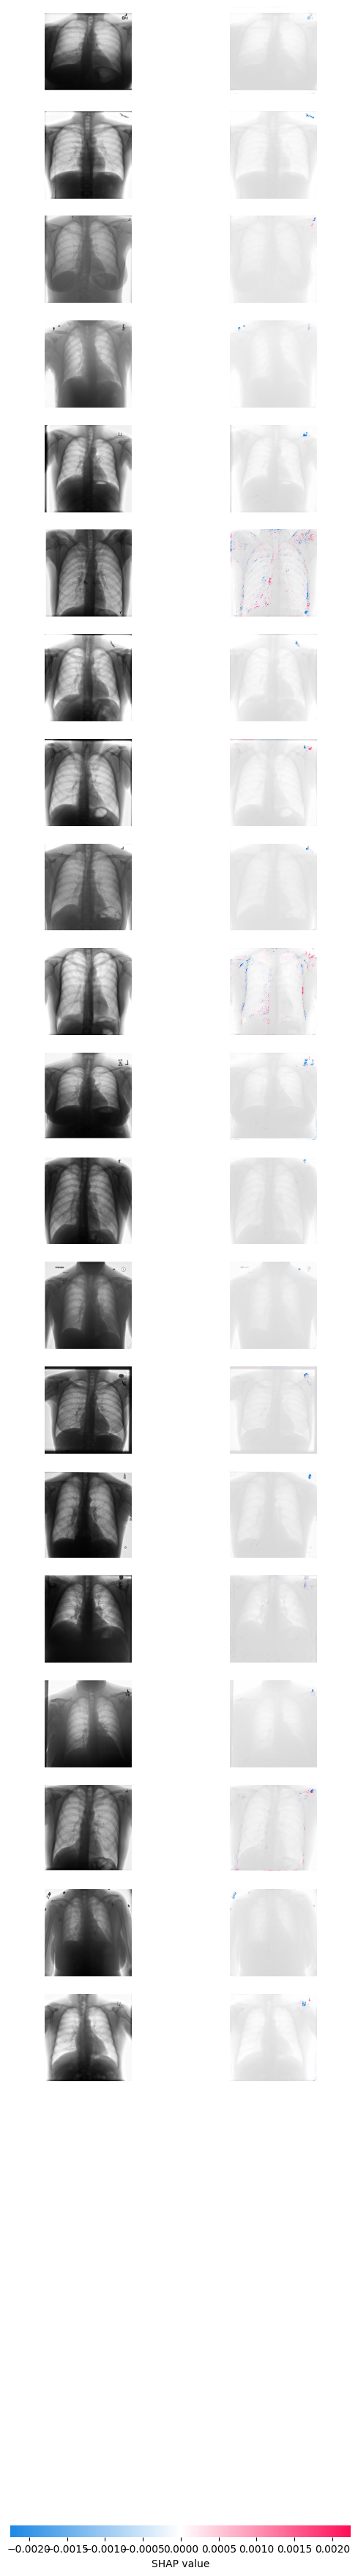

In [ ]:
# plot the feature attributions
shap.image_plot(shap_values, -newdata)